In [1]:
%pip install torch torchvision opencv-python pillow matplotlib seaborn pytest

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

In [3]:
import sys 
from pathlib import Path

# Get the absolute path to the base directory (one level up from notebook dir)
BASE_DIR = Path(__file__).resolve().parent.parent if "__file__" in globals() else Path.cwd().parent

# Add to sys.path if not already present
if str(BASE_DIR) not in sys.path:
    sys.path.insert(0, str(BASE_DIR))

# Now you can import directly
from zeromodel import ZeroModel

2025-08-20 22:55:41,272 - zeromodel.config - DEBUG - Added console logging handler
2025-08-20 22:55:41,273 - zeromodel.config - DEBUG - Added file logging handler: zeromodel.log
2025-08-20 22:55:41,274 - zeromodel.config - INFO - Logging configured at level: DEBUG
2025-08-20 22:55:41,275 - zeromodel.config - DEBUG - Configuration details:
2025-08-20 22:55:41,275 - zeromodel.config - DEBUG -   core: {'use_duckdb': False, 'duckdb_bypass_threshold': 0.5, 'precision': 8, 'normalize_inputs': True, 'nonlinearity_handling': 'auto', 'cache_preprocessed_vpm': True, 'max_cached_tasks': 100, 'default_output_precision': 'float32'}
2025-08-20 22:55:41,276 - zeromodel.config - DEBUG -   edge: {'enabled': False, 'default_tile_size': 3, 'output_precision': 'uint8', 'max_memory_usage': 25600}
2025-08-20 22:55:41,277 - zeromodel.config - DEBUG -   hierarchical: {'num_levels': 3, 'zoom_factor': 3, 'wavelet_type': 'haar'}
2025-08-20 22:55:41,277 - zeromodel.config - DEBUG -   logging: {'level': 'DEBUG', '

In [4]:
# demo_defects.py
import cv2
import glob
import numpy as np
from zeromodel.pipeline.executor import PipelineExecutor
from zeromodel.pipeline.maestro.group_normalize import GroupNormalizeFrames
from zeromodel.pipeline.maestro.encode import Encode
from zeromodel.pipeline.maestro.masking_stage import MaskingStage



In [5]:
def load_images(path, resize=(128,128)):
    imgs = []
    for fname in glob.glob(path):
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if resize:
            img = cv2.resize(img, resize)
        imgs.append({"frame": img.astype(np.float32)/255.0, "fname": fname})
    return imgs


In [6]:
    # load a mix of normal + defect
good = load_images("E:/data/mvtec_anomaly_detection/tile/test/good/*.png")
defect = load_images("E:/data/mvtec_anomaly_detection/tile/test/scratch/*/*.png")

context = {"frames_in": good[:5] + defect[:5]}

stages = [
    {"stage": "maestro.group_normalize.GroupNormalizeFrames",
        "params": {"groups": [[0,3]]}},   # normalize RGB together
    {"stage": "maestro.encode.Encode",
        "params": {"L": 8}},              # residual encoding
    {"stage": "maestro.masking_stage.MaskingStage",
        "params": {"mask_ratio": 0.5}},   # apply structured dropout
    {"stage": "maestro.anomaly_scorer.AnomalyScorer",
        "params": {"method": "mean"}},
]


executor = PipelineExecutor(stages)
dummy = np.zeros((1, 8, 8))  # (T,H,W) or (T,H,W,C)
_, ctx = executor.run(dummy, context)

print(ctx.keys())
print(ctx["stage_2"])


# retrieve encoded frames
for rec in ctx["stage_2"]["metadata"]["frames_maestro"]:
    print(rec["fname"], rec["residual"].mean(), rec["residual"].std())

for rec in ctx["stage_3"]["metadata"]["frames_scores"]:
    print(rec["fname"], rec["score"])



2025-08-20 22:55:43,055 - zeromodel.pipeline.executor - INFO - PipelineExecutor initialized with 4 stages
2025-08-20 22:55:43,056 - zeromodel.pipeline.executor - INFO - Executing pipeline with 4 stages
2025-08-20 22:55:43,057 - zeromodel.pipeline.executor - INFO - Executing stage 1/4: maestro.group_normalize.GroupNormalizeFrames
2025-08-20 22:55:43,058 - zeromodel.pipeline.maestro.group_normalize - DEBUG - [group_normalize] Frame 0, group 0: mean=0.4457, std=0.1099
2025-08-20 22:55:43,059 - zeromodel.pipeline.maestro.group_normalize - DEBUG - [group_normalize] Frame 1, group 0: mean=0.4318, std=0.1127
2025-08-20 22:55:43,060 - zeromodel.pipeline.maestro.group_normalize - DEBUG - [group_normalize] Frame 2, group 0: mean=0.4553, std=0.1096
2025-08-20 22:55:43,061 - zeromodel.pipeline.maestro.group_normalize - DEBUG - [group_normalize] Frame 3, group 0: mean=0.4305, std=0.1158
2025-08-20 22:55:43,062 - zeromodel.pipeline.maestro.group_normalize - DEBUG - [group_normalize] Frame 4, group 0

dict_keys(['frames_in', 'stage_0', 'stage_1', 'stage_2', 'stage_3', 'final_stats'])
{'stage': 'maestro.masking_stage.MaskingStage', 'input_shape': (1, 8, 8), 'output_shape': (1, 8, 8), 'elapsed_sec': 0.16225075721740723, 'metadata': {'enable_gif': True, 'gif_scale': 4, 'gif_fps': 6, 'frames_in': [{'frame': array([[[0.2784314 , 0.28627452, 0.26666668],
        [0.32941177, 0.32941177, 0.32156864],
        [0.3254902 , 0.3372549 , 0.3137255 ],
        ...,
        [0.4117647 , 0.4       , 0.4       ],
        [0.40392157, 0.37254903, 0.34509805],
        [0.3764706 , 0.3764706 , 0.34117648]],

       [[0.3019608 , 0.3137255 , 0.29803923],
        [0.3019608 , 0.3137255 , 0.28627452],
        [0.2901961 , 0.29803923, 0.27058825],
        ...,
        [0.34117648, 0.32941177, 0.3019608 ],
        [0.34509805, 0.32156864, 0.3372549 ],
        [0.37254903, 0.36078432, 0.34509805]],

       [[0.29411766, 0.29411766, 0.27058825],
        [0.2901961 , 0.30980393, 0.29411766],
        [0.3529412

2025-08-20 22:59:08,638 - zeromodel.pipeline.executor - INFO - Executing pipeline with 4 stages
2025-08-20 22:59:08,639 - zeromodel.pipeline.executor - INFO - Executing stage 1/4: maestro.group_normalize.GroupNormalizeFrames
2025-08-20 22:59:08,641 - zeromodel.pipeline.maestro.group_normalize - DEBUG - [group_normalize] Frame 0, group 0: mean=0.4457, std=0.1099
2025-08-20 22:59:08,642 - zeromodel.pipeline.maestro.group_normalize - DEBUG - [group_normalize] Frame 1, group 0: mean=0.4318, std=0.1127
2025-08-20 22:59:08,643 - zeromodel.pipeline.maestro.group_normalize - DEBUG - [group_normalize] Frame 2, group 0: mean=0.4553, std=0.1096
2025-08-20 22:59:08,644 - zeromodel.pipeline.maestro.group_normalize - DEBUG - [group_normalize] Frame 3, group 0: mean=0.4305, std=0.1158
2025-08-20 22:59:08,645 - zeromodel.pipeline.maestro.group_normalize - DEBUG - [group_normalize] Frame 4, group 0: mean=0.4324, std=0.1136
2025-08-20 22:59:08,646 - zeromodel.pipeline.maestro.group_normalize - DEBUG - [

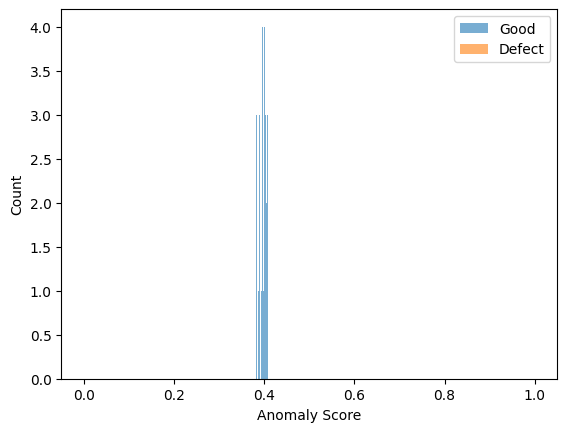

In [ ]:
import matplotlib.pyplot as plt

def collect_scores(paths, stages):
    imgs = load_images(paths)
    ctx = {"frames_in": imgs}
    _, ctx = executor.run(dummy, ctx)
    # return [rec["score"] for rec in ctx["frames_scores"]]
    return [rec["score"] for rec in ctx["stage_3"]["metadata"]["frames_scores"]]

good_scores =   collect_scores("E:/data/mvtec_anomaly_detection/tile/test/good/*.png", stages)
defect_scores = collect_scores("E:/data/mvtec_anomaly_detection/tile/test/rough/*.png", stages)

plt.hist(good_scores, bins=20, alpha=0.6, label="Good")
plt.hist(defect_scores, bins=20, alpha=0.6, label="Defect")
plt.xlabel("Anomaly Score")
plt.ylabel("Count")
plt.legend()
plt.show()
